## Goals: Preprocessing of training Data and Inference Data

Preprocessing, alignement and aggregation, into a single usable csv file, of : 
* Meteo data
* Waterflow discharge 
* DEM
* Soil composition
* Station position

Using informations in Hydrographic Areas.

![Alt text](../images/notebook-1.png)


### 1. Imports
Imports necessary libraries, sets up environment paths, and includes custom utility functions.


In [1]:
# Standard library imports
import os
import sys
from typing import Dict
import rioxarray

# Third-party library imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rioxarray.exceptions import NoDataInBounds 
from shapely.geometry import Point, box
import xarray as xr

# Modify sys.path to include custom modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))

from src.utils.preprocessing import prepare_kdtree, interpolate_variable, interpolate_and_merge_optimized, get_altitude
from src.utils.plots import plot_hydrographic_maps
from src.utils.data_loader import load_hydro_data, read_soil_data, read_altitude_data, load_water_flows, load_station_info, load_meteo_data

Defines constants :
* *DATASET_DIR* must be the directory where you unzip the *zenodo* dataset.
* *EVAL_DIR* will be used to store inference / evaluation data

In [2]:
#* REMOVE start_date / BBOX / AREAS WHEN FINAL *

start_date = '1990-01-01'
end_date = '2009-12-31'

BBOX = {
    "brazil": [-44.5, -21.5, -39.5, -17.5],
    "france": [-3, 42.0, 8, 49.0]
}

AREAS = ["brazil", "france"]
DATASET_DIR = "../../../dataset/"
EVAL_DIR = "../../../data/evaluation/"
INPUT_DIR = "../../../data/input/"

datasets = { "train": INPUT_DIR, "eval" : EVAL_DIR}

### 2. Data Loading and Initial Cleaning
* Hydrological divisions
* Climate data (precipitation, soil moisture, evaporation and temperature)
* Station metadata for localisation of water station
* Water flow discharge
* Digital elevation model
* And soil data.

In [3]:
gdf_region = {}
gdf_sector = {}
gdf_sub_sector = {}
gdf_zone = {}
precipitations = {}
temperatures = {}
soil_moisture = {}
evaporation = {}
stations = {}
water_flows = {}
soil_ds = {}

for area in AREAS:
    print("Processing", area)

    # 1. Load hydrographic data
    hydro_data = load_hydro_data(area, DATASET_DIR)
    gdf_region[area] = hydro_data['region']
    gdf_sector[area] = hydro_data['sector']
    gdf_sub_sector[area] = hydro_data['sub_sector']
    gdf_zone[area] = hydro_data['zone']

    # 2. Load soil composition data
    soil_ds[area] = read_soil_data(area, DATASET_DIR)

    # 3. Load altitude data
    dem = read_altitude_data(area, DATASET_DIR)
    
    for type, dataset in datasets.items():
        print("Processing", type)

        key = f"{type}_{area}"

        # 4. Loading meteo data
        meteo = load_meteo_data(area, type, DATASET_DIR)
        precipitations[key] = meteo["precipitations"]
        temperatures[key]   = meteo["temperatures"]
        soil_moisture[key]  = meteo["soil_moisture"]
        evaporation[key]    = meteo["evaporation"]
        
        # 5. Load station info
        stations[key] = load_station_info(area, type, DATASET_DIR)
        stations[key]['altitude'] = stations[key].apply(lambda x: get_altitude(x['latitude'], x['longitude'], dem), axis=1)

        # 6. Load water flows
        water_flows[key] = load_water_flows(area, type, DATASET_DIR)



Processing brazil
Processing train
Processing eval
Processing france
Processing train
Processing eval


Adding rows for predictions within water_flows this is specific to the inference / evaluation data pre-processing the new line correspond to the first week to be infered.

In [4]:
for area in AREAS:
    print("Processing", area)
    key = f"eval_{area}"
    new_dfs = []
    block_size = 4

    for i in range(0, len(water_flows[key]), block_size):
        block = water_flows[key].iloc[i : i + block_size].copy()
        new_dfs.append(block)
        
        if len(block) == block_size:
            last_row = block.iloc[-1].copy()
            last_row['ObsDate'] = last_row['ObsDate'] + pd.Timedelta(days=7)
            last_row['discharge'] = float('nan')
            new_dfs.append(pd.DataFrame([last_row]))

    water_flows[key] = pd.concat(new_dfs, ignore_index=True)

Processing brazil
Processing france


### 3. Hydrographic Area Association 
Adding corresponding Hydrological divisions (*'regions'*, *'secteurs'*, *'sous-secteurs'*, and *'zones'* - and equivalent for Brazil) for every station.

> All the stations have discharge information and will be used later on.

In [5]:
for area in AREAS:
    print("Processing", area)
    for type, dataset in datasets.items():
        print("Processing", type)
        key = f"{type}_{area}"

        stations[key]['geometry'] = stations[key].apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
        gdf_stations = gpd.GeoDataFrame(stations[key], geometry='geometry', crs="EPSG:4326")

        for hydro in (gdf_region, gdf_sector, gdf_sub_sector, gdf_zone):
            hydro[area] = hydro[area].to_crs(gdf_stations.crs)

        # Set join parameters based on the area
        if area == "france":
            join_info = {
                "region":    ("CdRegionHydro",      "_stations",      "_region"),
                "sector":    ("CdSecteurHydro",     "_stations",      "_sector"),
                "sub_sector":("CdSousSecteurHydro", "_stations",      "_sub_sector"),
                "zone":      ("CdZoneHydro",        "_stations",      "_zone")
            }
        elif area == "brazil":
            join_info = {
                "region":    ("wts_pk", "_stations_region", "_region"),
                "sector":    ("wts_pk", "_stations_sector", "_sector"),
                "sub_sector":("wts_pk", "_stations_sub_sector", "_sub_sector"),
                "zone":      ("wts_pk", "_stations_zone", "_zone")
            }
        else:
            continue  # Skip unsupported areas

        # Map layer names to their corresponding GeoDataFrames
        hydro_dict = {
            "region":     gdf_region[area],
            "sector":     gdf_sector[area],
            "sub_sector": gdf_sub_sector[area],
            "zone":       gdf_zone[area]
        }

        # Perform spatial joins for each hydrographic layer in a loop
        for level, (col, lsuffix, rsuffix) in join_info.items():
            gdf_stations = gpd.sjoin(
                gdf_stations,
                hydro_dict[level][['geometry', col]],
                how="left",
                predicate="within",
                lsuffix=lsuffix,
                rsuffix=rsuffix
            )

        # Drop the geometry column if it's no longer needed
        stations[key] = gdf_stations.drop(columns=['geometry'])

Processing brazil
Processing train
Processing eval
Processing france
Processing train
Processing eval


### 4. Filter and Prepare Spatial Data

Filter hydrological divisions to keep only relevant (*'regions'*, *'secteurs'*, *'sous-secteurs'*, and *'zones'* - and equivalent for Brazil) based on associated station data.

> We remove hydrological divisions where there are no stations.

In [6]:
gdf_list = {}
for area in AREAS:
    # eval have all used stations train just have a subset of used stations
    key = f"eval_{area}"

    print("Processing", area)
    gdf_region[area] = gdf_region[area][gdf_region[area].index.isin(stations[key]['index__region'].unique())]
    gdf_sector[area] = gdf_sector[area][gdf_sector[area].index.isin(stations[key]['index__sector'].unique())]
    gdf_sub_sector[area] = gdf_sub_sector[area][gdf_sub_sector[area].index.isin(stations[key]['index__sub_sector'].unique())]
    gdf_zone[area] = gdf_zone[area][gdf_zone[area].index.isin(stations[key]['index__zone'].unique())]
    gdf_region[area].name = "index__region"
    gdf_sector[area].name = "index__sector"
    gdf_sub_sector[area].name = "index__sub_sector"
    gdf_zone[area].name = "index__zone"
    gdf_list[area] = [gdf_region[area], gdf_sector[area], gdf_sub_sector[area], gdf_zone[area]]

Processing brazil
Processing france


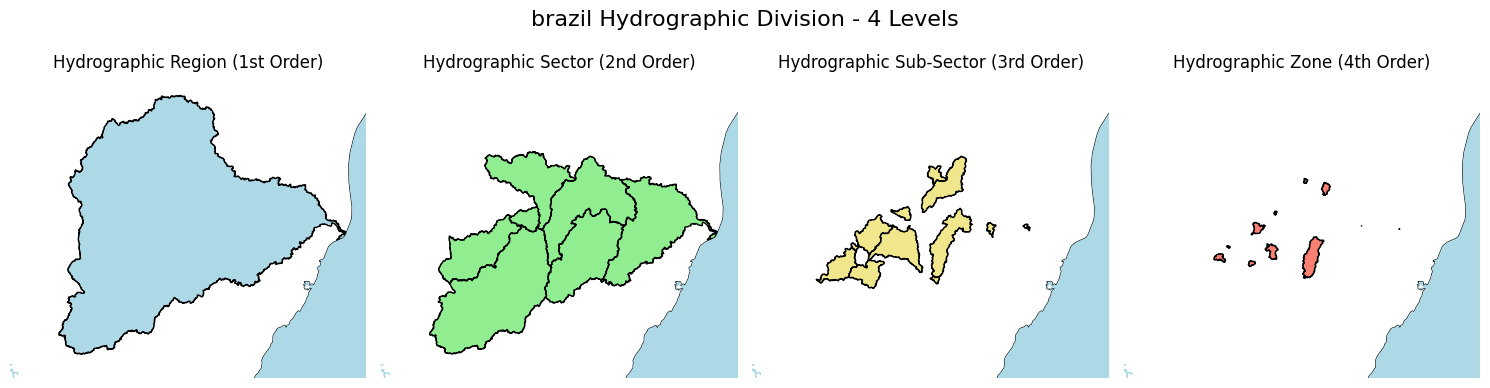

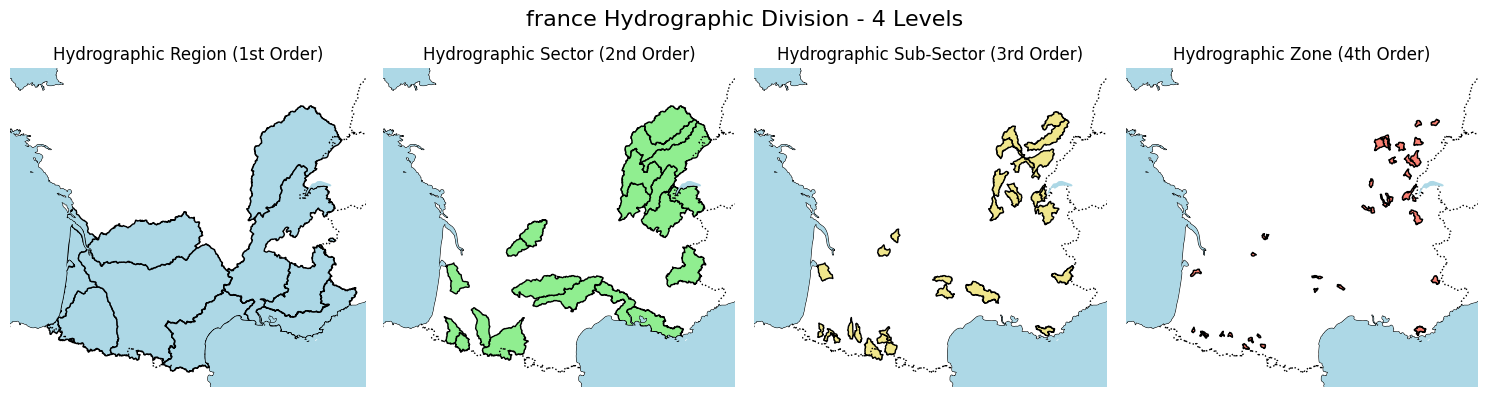

In [7]:
for area in AREAS:
    plot_hydrographic_maps(area, {
        "region": gdf_region,
        "sector": gdf_sector,
        "sub_sector": gdf_sub_sector,
        "zone": gdf_zone
    }, BBOX)


### 5. Soil Data aggregation
Mean estimation of soil composition : 
* Bulk density
* Coarse fragments volumetric fraction
* Clay particles 
* Sand particles

Aggregated at the 4 hydrological division levels and 6 depth intervals.
> This step can take several minutes

In [8]:
for area in AREAS:
    print("Processing", area)
    name_soil_var = []
    soil_ds[area] = soil_ds[area].rename({var: var.replace(f"{area}_", "") for var in soil_ds[area].data_vars})
    for gdf in gdf_list[area]: # 4 hydrological divisions
        print(gdf.name)
        for soil_data in soil_ds[area].data_vars:
            name_soil_var.append(f"{soil_data}_{gdf.name}")
            for idx, row in gdf.iterrows():
                region_geom = [row.geometry].copy()
                try:
                    clipped_bdod = soil_ds[area][soil_data].rio.clip(region_geom, gdf.crs)
                    mean_val = float(clipped_bdod.mean().values)
                except NoDataInBounds:
                    mean_val = np.nan
                    print(f"No data in bounds for {soil_data}_{gdf.name}")
                gdf.loc[idx, f"{soil_data}_{gdf.name}"] = mean_val
                

Processing brazil
index__region
index__sector
index__sub_sector
index__zone
Processing france
index__region


/Users/gk/repos/Hackathon-Water-Scarcity/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/gk/repos/Hackathon-Water-Scarcity/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/gk/repos/Hackathon-Water-Scarcity/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value

index__sector


/Users/gk/repos/Hackathon-Water-Scarcity/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/gk/repos/Hackathon-Water-Scarcity/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/gk/repos/Hackathon-Water-Scarcity/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value

index__sub_sector


/Users/gk/repos/Hackathon-Water-Scarcity/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/gk/repos/Hackathon-Water-Scarcity/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/gk/repos/Hackathon-Water-Scarcity/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value

index__zone


/Users/gk/repos/Hackathon-Water-Scarcity/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/gk/repos/Hackathon-Water-Scarcity/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/gk/repos/Hackathon-Water-Scarcity/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value

### 6. Prepare Climate and Water Flow Data

Convert meteo variables 
* Temperature 
* Precipitation
* Soil moisture
* Evaporation

to DataFrames.

In [9]:
df_temperatures = {}
df_precipitations = {}
df_soil_moisture = {}
df_evaporation = {}
for area in AREAS:
    print("Processing", area)

    for type, dataset in datasets.items():
        key = f"{type}_{area}"
        print("Processing", type)
        
        for source, col, dest in [
            (temperatures, "t2m", df_temperatures),
            (precipitations, "tp", df_precipitations),
            (soil_moisture, "swvl1", df_soil_moisture),
            (evaporation, "e", df_evaporation)
        ]:
            dest[key] = (
                source[key]
                .to_dataframe()
                .reset_index()
                .filter(items=["valid_time", "latitude", "longitude", col])
                .rename(columns={"valid_time": "ObsDate"})
                .fillna(0)
            )


Processing brazil
Processing train
Processing eval
Processing france
Processing train
Processing eval


### 7. Merge water flow dataset with station 

TO REMOVE WARNING KEEP IN TRAINING

Merge water_flows dataset with station to retrieve stations informations (latitude, longitude, altitude, hydrographic divisions)

In [10]:
for area in AREAS:    
    print("Processing", area)
    for type in datasets.keys():
        key = f"{type}_{area}"
        print("Processing", type)

        water_flows[key] = water_flows[key].merge(
            stations[key],
            on="station_code",
            how="left"
        )

Processing brazil
Processing train
Processing eval
Processing france
Processing train
Processing eval


### 8. Clean and Align Water Flow Data

Filter water flow data to match the specified time period. Identify and remove stations with invalid (negative) water flow values.

In [11]:
for area in AREAS:
    print("Processing", area)
    for type in datasets.keys():
        key = f"{type}_{area}"
        print("Processing", type)

        water_flows[key] = water_flows[key][["discharge",
                                                "latitude",
                                                "longitude",
                                                "catchment",
                                                "altitude",
                                                "index__sector",
                                                "index__sub_sector",
                                                "index__zone",
                                                "index__region",
                                                "station_code",
                                                "ObsDate"]].copy()




Processing brazil
Processing train
Processing eval
Processing france
Processing train
Processing eval


### 9. Spatial Interpolation and aggregation of the Meteo data

Perform interpolation and merge at the 4 hydrological division levels.

In [12]:
for area in AREAS:
    print("Processing", area)
    for type in datasets.keys():
        key = f"{type}_{area}"
        print("Processing", type)

        kdtree = prepare_kdtree(
            precipitations[key].latitude.values,
            precipitations[key].longitude.values
        )

        # Interpolate each meteo variable and store the result in water_flows
        measurement_data = {
            "precipitations": precipitations[key].tp,
            "temperatures": temperatures[key].t2m,
            "soil_moisture": soil_moisture[key].swvl1,
            "evaporation": evaporation[key].e,
        }
        for meteo_key, data in measurement_data.items():
            water_flows[key][meteo_key] = interpolate_variable(water_flows[key], kdtree, data)

        # Define spatial groups with their corresponding GeoDataFrame and index column name
        groups = [
            ("region", gdf_region[area], "index__region"),
            ("zone", gdf_zone[area], "index__zone"),
            ("sector", gdf_sector[area], "index__sector"),
            ("sub_sector", gdf_sub_sector[area], "index__sub_sector"),
        ]

        # Define measurements for merging with the appropriate singular names
        merge_measurements = {
            "precipitation": precipitations[key].tp,
            "temperature": temperatures[key].t2m,
            "soil_moisture": soil_moisture[key].swvl1,
            "evaporation": evaporation[key].e,
        }

        # Process all combinations of measurements and spatial groups
        for group_name, gdf, idx_col in groups:
            for meas, data in merge_measurements.items():
                col_name = f"{meas}_{group_name}"
                water_flows[key] = interpolate_and_merge_optimized(
                    water_flows[key], kdtree, data, gdf, col_name, idx_col
                )


Processing brazil
Processing train
Processing eval
Processing france
Processing train
Processing eval


### 10. Merge Soil Data with Water Flow Data

In [13]:
for area in AREAS:
    print("Processing", area)
    for type in datasets.keys():
        key = f"{type}_{area}"
        print("Processing", type)

        for gdf in gdf_list[area]:
            cols = [col for col in gdf.columns if col in name_soil_var]
            water_flows[key] = water_flows[key].merge(gdf[cols], left_on=gdf.name, how="left", right_index=True)

Processing brazil
Processing train
Processing eval
Processing france
Processing train
Processing eval


### 11. Create Lagged Water Flow and Meteo Features

Create lagged features for one and two weeks to capture temporal dependencies, and for meteo variable (Temperatures, Precipitations and Evaporations)

In [14]:

dataset_baseline = {}

for key in water_flows.keys():
    print("Processing", key)

    water_flows[key] = water_flows[key].reset_index()
    water_flows[key]['ObsDate'] = pd.to_datetime(water_flows[key]['ObsDate'])
    df = water_flows[key].copy()

    dataset_baseline[key] = (
        df
        .groupby(['station_code', pd.Grouper(key='ObsDate', freq='W')])
        .mean()
        .reset_index()
    )


    dataset_baseline[key]['water_flow_lag_1w'] = (
        dataset_baseline[key]
        .groupby('station_code')['discharge']
        .shift(1)
    )

    dataset_baseline[key]['water_flow_lag_2w'] = (
        dataset_baseline[key]
        .groupby('station_code')['discharge']
        .shift(2)
    )

    # Create lagged precipitation, temperature, evaporation features (previous values for -1 week)
    for col in dataset_baseline[key].columns:
        if col.startswith("precipitation") or col.startswith("temperature") or col.startswith("evaporation"):
            dataset_baseline[key][f"{col}_lag_1w"] = (
                dataset_baseline[key]
                .groupby('station_code')[col]
                .shift(1)
            )
    
    # If we are in the train dataset, we can create the target variables for the next 4 weeks
    if key.startswith("train"):
        dataset_baseline[key]['water_flow_lag_2w'] = (
            dataset_baseline[key]
            .groupby('station_code')['discharge']
            .shift(2)
        )
        dataset_baseline[key]['water_flow_week2'] = (
            dataset_baseline[key]
            .groupby('station_code')['discharge']
            .shift(-1)
        )
        dataset_baseline[key]['water_flow_week3'] = (
            dataset_baseline[key]
            .groupby('station_code')['discharge']
            .shift(-2)
        )
        dataset_baseline[key]['water_flow_week4'] = (
            dataset_baseline[key]
            .groupby('station_code')['discharge']
            .shift(-3)
        )

        dataset_baseline[key] = dataset_baseline[key].rename(columns={"discharge": "water_flow_week1"})

    dataset_baseline[key] = dataset_baseline[key].dropna(subset=['water_flow_lag_1w'])
    dataset_baseline[key] = dataset_baseline[key].dropna(subset=['water_flow_lag_2w'])

    # add CdRegionHydro, CdSecteurHydro, CdSousSecteurHydro, CdZoneHydro from water_flows

    columns = ['station_code']

    dataset_baseline[key] = dataset_baseline[key].merge(
        water_flows[key][columns].drop_duplicates(),
        on='station_code',
        how='left'
    )


Processing train_brazil
Processing eval_brazil
Processing train_france
Processing eval_france


### 12. We remove the rows where no predictions are needed

And remove the discharge column from the *eval* dataset.

In [15]:
for area in AREAS:
    print("Processing", area)
    key = f"eval_{area}"

    # Only keep the inference rows
    missing_values = dataset_baseline[key]["discharge"].isnull()
    dataset_baseline[key] = dataset_baseline[key][missing_values]

# drop discharge column
for area in AREAS:
    key = f"eval_{area}"
    print("Processing", area)
    dataset_baseline[key] = dataset_baseline[key].drop(columns=["discharge"])


Processing brazil
Processing france
Processing brazil
Processing france


### 13. Saving Pre-processed Dataset

In [16]:
# Saving data
for area in AREAS:
    print("Processing", area)
    for type, path in datasets.items():
        key = f"{type}_{area}"

        path_dataset_baseline = f"{path}/preprocessed_{area}.csv"

        if not os.path.exists(path):
            os.makedirs(path)
        dataset_baseline[key].to_csv(path_dataset_baseline)


Processing brazil
Processing france
